# OPIS

Cilj je kreirati model koji automatski određuje koje pristupe treba dati zaposlenima u kompaniji na osnovu njihove uloge, koristeći istorijske podatke o pristupima. Ovo će smanjiti potrebu za ručnim odobravanjem ili oduzimanjem pristupa kako se zaposleni kreću kroz različite uloge unutar firme, čime se štedi vreme i novac. Model će analizirati ulogu zaposlenog i kod resursa da bi odlučio o odobravanju pristupa.

## 1. Ucitavanje i razumevanje podataka

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
podaci = pd.read_csv('train.csv')
podaci.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [3]:
#Dataset sadrzi 32769 redova i 10 kolona. Izlazna varijabla je ACTION

print(podaci.shape)

(32769, 10)


In [4]:
# vidimo da su svi podaci int tipa i da nemaju null vrednosti
podaci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [5]:
# Proveravamo koliko jedinstvenih vrednosti po svakoj koloni imamo

podaci.nunique()

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

<Axes: xlabel='ACTION', ylabel='count'>

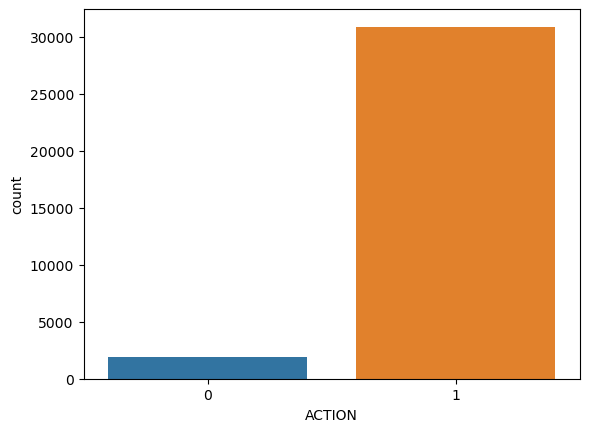

In [6]:
## Na osnovu plota vidimo da imamo problem NEBALANSIRANIH KLASA

sns.countplot(x='ACTION', data=podaci)

In [7]:
# Posmatramo koliko puta je neki resurs bio odobren ili odbijen.

odobrenje_resursa = podaci.groupby('RESOURCE')['ACTION'].value_counts().unstack(fill_value=0)
odobrenje_resursa['Total'] = odobrenje_resursa.sum(axis=1)
odobrenje_resursa  = odobrenje_resursa.sort_values(by='Total', ascending=False)
odobrenje_resursa

ACTION,0,1,Total
RESOURCE,,,
4675,3,836,839
79092,16,468,484
25993,19,390,409
75078,4,405,409
3853,6,398,404
...,...,...,...
31181,0,1,1
41851,0,1,1
31045,0,1,1


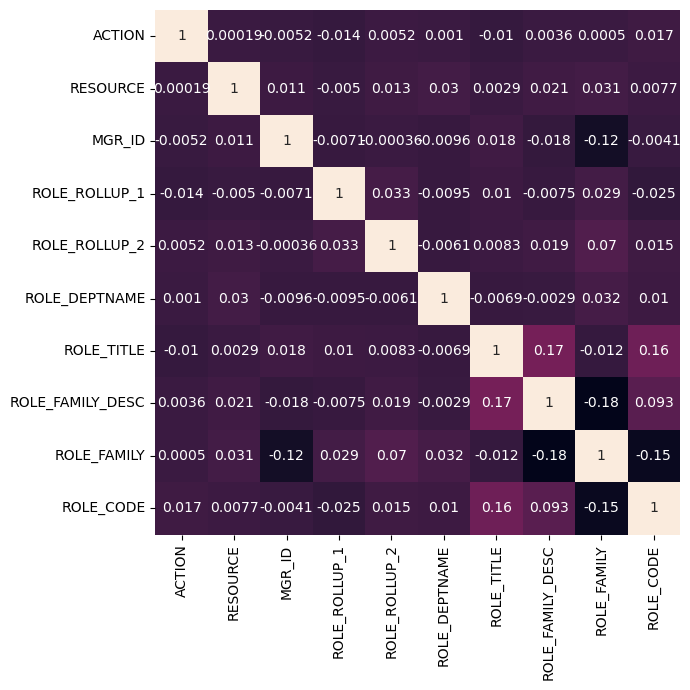

In [8]:
 ## 2. Priprema podataka

In [9]:
## Izdvajanje izlazne varijable

y = podaci['ACTION']
X = podaci.drop(columns='ACTION') 

X.head()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: ACTION, dtype: int64

In [10]:
# Potvrdjujemo da nema null vrednosti

print(X.isnull().sum())

RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64


#### Deljenje podataka na treining i test set koriscenjem Stratified Shuffle Split-a zbog nebalanisiranosti klasa

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    strat_train_set = podaci.iloc[train_index]
    strat_test_set = podaci.iloc[test_index]

X_train = strat_train_set.drop('ACTION', axis=1)
y_train = strat_train_set['ACTION'].copy()
X_test = strat_test_set.drop('ACTION', axis=1)
y_test = strat_test_set['ACTION'].copy()

X_train.shape, X_test.shape

((26215, 9), (6554, 9))

In [12]:
kategorickiAtributi = list(X.columns)
kategorickiAtributi

kategorickiPipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('categ_enc', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer([('categ_process', kategorickiPipeline, kategorickiAtributi)], remainder='passthrough')

X_train_transformed = preprocess.fit_transform(X_train)
X_test_transformed = preprocess.transform(X_test)
X_train_transformed.shape, X_test_transformed.shape

((26215, 14410), (6554, 14410))

In [13]:
feature_columns = list(preprocess.transformers_[0][1]['categ_enc'].get_feature_names_out(kategorickiAtributi))
len(feature_columns)

14410

# 3. Primene modela

In [14]:
def plot_feature_importance(feature_columns, importance_values, top_n_features=10):
    feature_imp = [ col for col in zip(feature_columns, importance_values)]
    feature_imp.sort(key=lambda x:x[1], reverse=True)
    
    if top_n_features:
        imp = pd.DataFrame(feature_imp[0:top_n_features], columns=['feature', 'importance'])
    else:
        imp = pd.DataFrame(feature_imp, columns=['feature', 'importance'])
    plt.figure(figsize=(10, 8))
    sns.barplot(y='feature', x='importance', data=imp, orient='h')
    plt.title('Most Important Features', fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xlabel("")
    plt.show()

### Stablo odlucivanja

In [15]:
modelDrvo = DecisionTreeClassifier()
modelDrvo.fit(X_train_transformed, y_train)

DecisionTreeClassifier()

In [17]:
scores_train = cross_val_score(modelDrvo, X_train_transformed, y_train, cv=10, scoring='roc_auc')
print(scores_train.mean())
scores_test = cross_val_score(modelDrvo, X_test_transformed, y_test, cv=10, scoring='roc_auc')
print(scores_test.mean())

0.701183983701027
0.6349448892646482


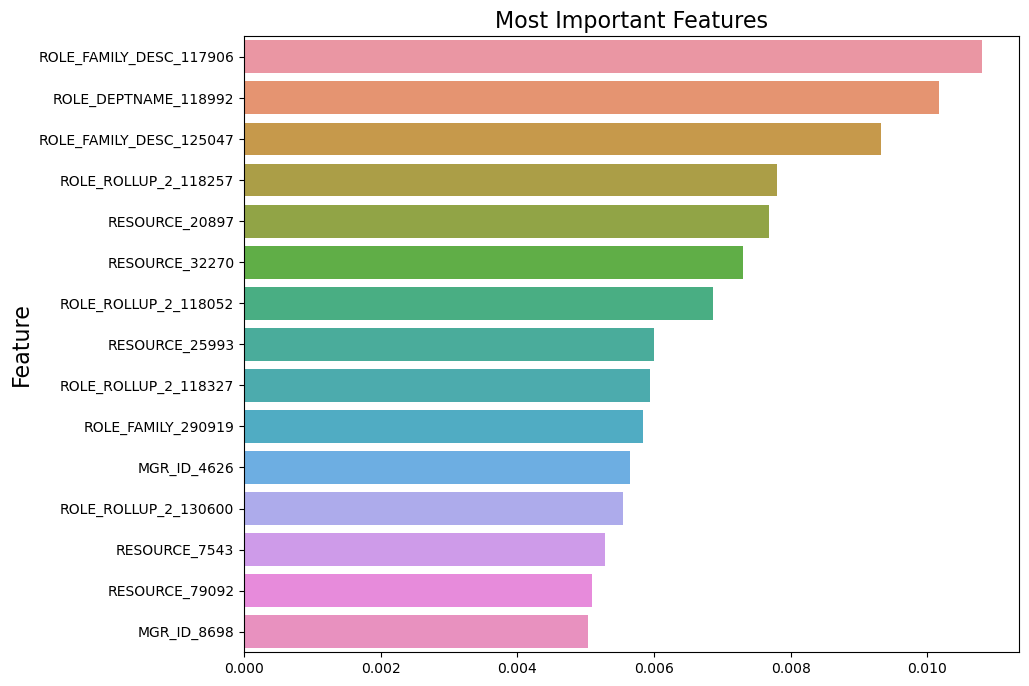

In [19]:
plot_feature_importance(feature_columns, modelDrvo.feature_importances_, top_n_features=15)

### Logisticka regresija

In [20]:
logistickaRegresija = LogisticRegression()
logistickaRegresija.fit(X_train_transformed, y_train)

LogisticRegression()

In [22]:
scores_train = cross_val_score(logistickaRegresija, X_train_transformed, y_train, cv=10, scoring='roc_auc')
print(scores_train.mean())
scores_test = cross_val_score(logistickaRegresija, X_test_transformed, y_test, cv=10, scoring='roc_auc')
print(scores_test.mean())

0.8537470571917514
0.7671728340456377


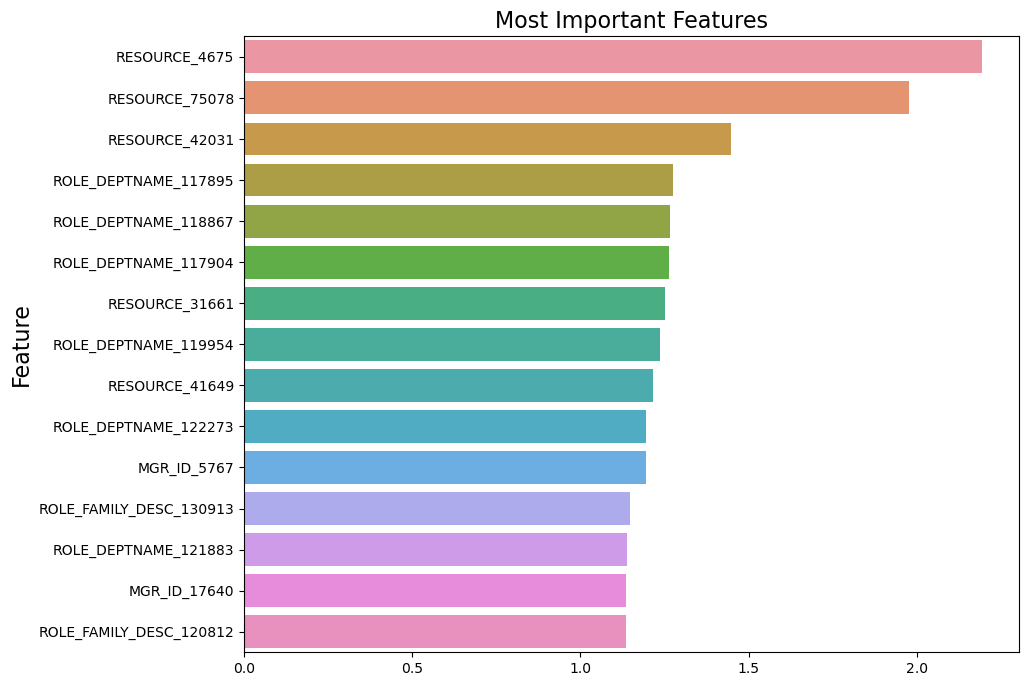

In [23]:
plot_feature_importance(feature_columns, logistickaRegresija.coef_[0], top_n_features=15)

### KNN

In [24]:
modelKNN = KNeighborsClassifier()
modelKNN.fit(X_train_transformed, y_train)

KNeighborsClassifier()

In [26]:
scores_train = cross_val_score(modelKNN, X_train_transformed, y_train, cv=10, scoring='roc_auc')
print(scores_train.mean())
scores_test = cross_val_score(modelKNN, X_test_transformed, y_test, cv=10, scoring='roc_auc')
print(scores_test.mean())

0.8126110544472501
0.7128833426152756


### Voting

In [29]:
logistickaRegresijaPipeline = Pipeline([('preprocess', preprocess), ('logistickaRegresija', logistickaRegresija)])
drvoPipeline = Pipeline([('preprocess', preprocess), ('modelDrvo', modelDrvo)])
KNNPipline = Pipeline([('preprocess', preprocess), ('modelKNN', modelKNN)])


estimators = [('logistickaRegresija', logistickaRegresijaPipeline), ('modelDrvo',drvoPipeline), 
                    ('modelKNN', KNNPipline)]

In [31]:
voting_reg = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
voting_reg.fit(X_train, y_train)

VotingClassifier(estimators=[('logistickaRegresija',
                              Pipeline(steps=[('preprocess',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('categ_process',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('categ_enc',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['RESOURCE',
                                                                                 'MGR_ID',
                                                                                 'ROLE_ROLLUP_1',
                                                                                 'ROLE_ROLLUP_2',
                                                                                 'ROLE_DEPTNAME',
                                                                                 'RO...
                                                                 transformers=[('categ_process',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('categ_enc',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['RESOURCE',
                                                                                 'MGR_ID',
                                                                                 'ROLE_ROLLUP_1',
                                                                                 'ROLE_ROLLUP_2',
                                                                                 'ROLE_DEPTNAME',
                                                                                 'ROLE_TITLE',
                                                                                 'ROLE_FAMILY_DESC',
                                                                                 'ROLE_FAMILY',
                                                                                 'ROLE_CODE'])])),
                                              ('modelKNN',
                                               KNeighborsClassifier())]))],
                 n_jobs=-1, voting='soft')

In [32]:
scores_train = cross_val_score(voting_reg, X_train, y_train, cv=10, scoring='roc_auc')
print(scores_train.mean())
scores_test = cross_val_score(voting_reg, X_test, y_test, cv=10, scoring='roc_auc')
print(scores_test.mean())

0.8624084112397934
0.761418299501006


### Stacking

In [35]:
modelStacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
modelStacking.fit(X_train, y_train)
# STACKING
scores = cross_val_score(modelStacking,  X_train, y_train, cv=10, scoring='roc_auc',n_jobs =4)
print(scores.mean())
scores_test = cross_val_score(modelStacking, X_test, y_test, cv=10, scoring='roc_auc',n_jobs =4)
print(scores_test.mean())

0.8639563813030756
0.7640363030341055


### 3.1 Optimizacija parametara

In [44]:
# Parametri za stablo
param_grid_decision_tree = {
    'modelDrvo__modelDrvo__max_depth': [3, 5, 7],
    'modelDrvo__modelDrvo__min_samples_split': [2, 5, 10]
}

# Parametri za Knn
param_grid_knn = {
    'modelKNN__modelKNN__n_neighbors': [3, 5, 7]
}

# Parametri za logisticku
param_grid_logistic_regression = {
    'logistickaRegresija__logistickaRegresija__C': [0.1, 1.0, 10.0]
}

# Parametri za stacking
#param_grid_stacking_classifier = {
    #'final_estimator__C': [0.1, 1.0, 10.0]
#}

param_grid = {**param_grid_decision_tree, **param_grid_knn, **param_grid_logistic_regression}

gridSearch = GridSearchCV(estimator=modelStacking, param_grid=param_grid, cv=5,scoring='roc_auc',n_jobs = 4)
gridSearch.fit(X_train, y_train)

print("Najbolji parametri:", gridSearch.best_params_)
print("Najbolja ocena:", gridSearch.best_score_)

Najbolji parametri: {'logistickaRegresija__logistickaRegresija__C': 1.0, 'modelDrvo__modelDrvo__max_depth': 3, 'modelDrvo__modelDrvo__min_samples_split': 2, 'modelKNN__modelKNN__n_neighbors': 3}
Najbolja ocena: 0.8553921378281124


In [47]:
najboljiModel = gridSearch.best_estimator_

In [48]:
predikcije = najboljiModel.predict(X_test)

In [54]:
rocAuc = roc_auc_score(y_test, predikcije)
print("ROC AUC ocena:", rocAuc)

ROC AUC ocena: 0.6156803008129212


### 3.2 Selekcija atributa

In [55]:
selection = SelectKBest(k=1000, score_func=f_classif)
X_train_transformed_reduced = selection.fit_transform(X_train_transformed, y_train)
X_train_transformed_reduced.shape

(26215, 1000)

In [56]:
X_test_transformed_reduced = selection.fit_transform(X_test_transformed, y_test)
X_test_transformed_reduced.shape

(6554, 1000)

#### Logisticka sa selektovanim

In [58]:
scores_train = cross_val_score(logistickaRegresija, X_train_transformed_reduced, y_train, cv=10, scoring='roc_auc')
print(scores_train.mean())
scores_test = cross_val_score(logistickaRegresija, X_test_transformed_reduced, y_test, cv=10, scoring='roc_auc')
print(scores_test.mean())

0.8507993516601241
0.7846897593304747


#### Stablo sa selektovanim

In [59]:
scores_train = cross_val_score(modelDrvo, X_train_transformed_reduced, y_train, cv=10, scoring='roc_auc')
print(scores_train.mean())
scores_test = cross_val_score(modelDrvo, X_test_transformed_reduced, y_test, cv=10, scoring='roc_auc')
print(scores_test.mean())

0.7515781301068822
0.6301737048120288


#### Knn sa selektovanim

In [61]:
scores_train = cross_val_score(modelKNN, X_train_transformed_reduced, y_train, cv=10, scoring='roc_auc')
print(scores_train.mean())
scores_test = cross_val_score(modelKNN, X_test_transformed_reduced, y_test, cv=10, scoring='roc_auc')
print(scores_test.mean())

0.7634449877230771
0.685433995418113


# 4. Evaluacija

In [63]:
def plot_custom_roc_curve(clf_name, y_true, y_scores):
    auc_score = np.round(roc_auc_score(y_true, y_scores), 3)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, linewidth=2, label=clf_name+" (AUC Score: {})".format(str(auc_score)))
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("FP", fontsize=16)
    plt.ylabel("TP", fontsize=16)
    plt.legend()

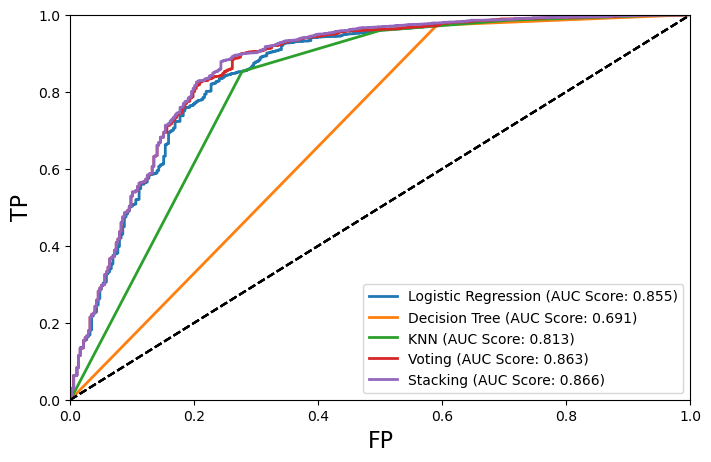

In [64]:
plt.figure(figsize=(8, 5))
plot_custom_roc_curve('Logistic Regression', y_test, logistickaRegresija.decision_function(X_test_transformed))
plot_custom_roc_curve('Decision Tree', y_test, modelDrvo.predict_proba(X_test_transformed)[:,1])
plot_custom_roc_curve('KNN', y_test, modelKNN.predict_proba(X_test_transformed)[:,1])
plot_custom_roc_curve('Voting', y_test, voting_reg.predict_proba(X_test)[:,1])
plot_custom_roc_curve('Stacking', y_test, modelStacking.predict_proba(X_test)[:,1])
plt.show()

#### 1. Logisticka regresija

0.8537470571917514

0.7671728340456377

#### 2. Stablo odlucivanja

0.701183983701027

0.6349448892646482

#### 3. KNN

0.8126110544472501

0.7128833426152756

#### 4. Voting

0.8624084112397934

0.761418299501006

#### 5. Stacking

0.8639563813030756

0.7640363030341055

#### 6. Stacking sa optimizovanim estimatorima

0.8553921378281124

0.6156803008129212

#### 7. Logisticka sa selektovanim

0.8507993516601241

0.7846897593304747

#### 8. Stablo sa selektovanim

0.7515781301068822

0.6301737048120288

#### 9. Knn sa selektovanim

0.7634449877230771

0.685433995418113
